# Pré-processamento de dados

Neste arquivo será realizado o pré-processamento de dados, bem como filtros temporais, espaciais e visualização de dados em gráficos.

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal

In [7]:
# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=250, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=250, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=250, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=250, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    print(low, high)
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

### Visualização dos gráficos com e sem filtros

... explicação (**tarefa** completar a explicação).

In [8]:
def print_graphs(X):
    for i in range(X.shape[1]):
        plt.plot(X[:,i])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(X.shape[1]):
        plt.psd(X[:,i], Fs=250)
    plt.title('Domínio da frequência')
    plt.show()

(1291544,)


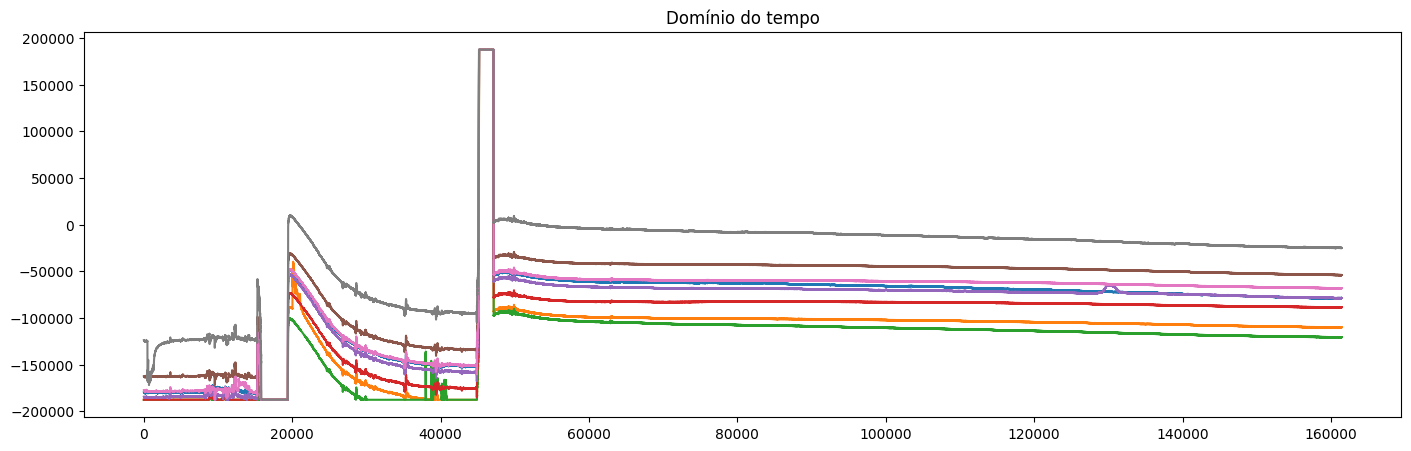

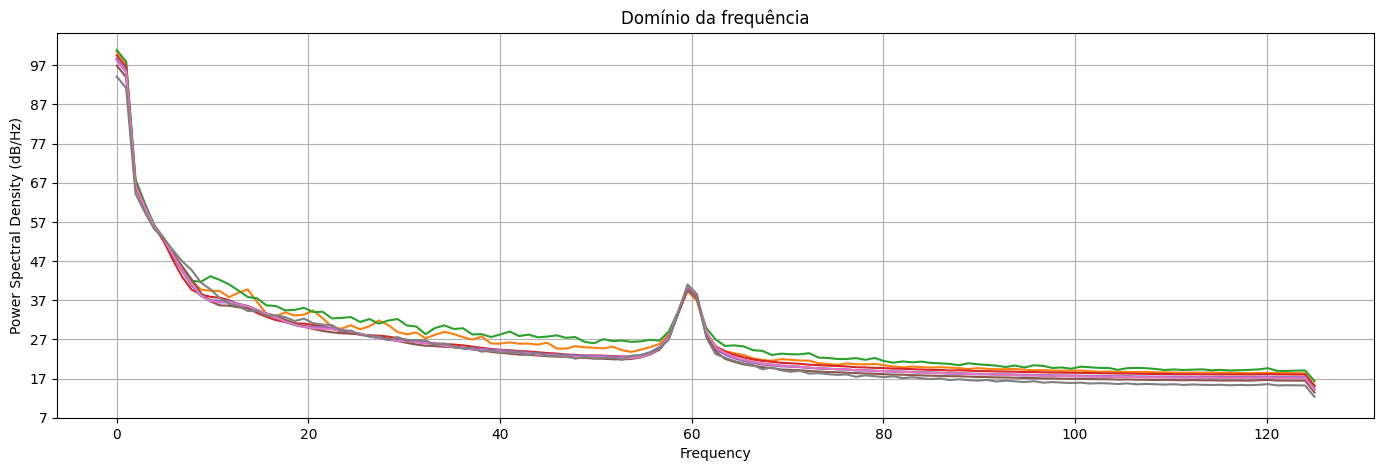

In [9]:
# Apresentação dos dados sem aplicação dos filtros.

data = np.load('../data.npy')
print(data.flatten().shape)

rcParams['figure.figsize'] = [17., 5.]
print_graphs(data)

### Aplicação do filtro Notch

Removendo principalmente dados de interferência da rede elétrica.

0.472 0.488


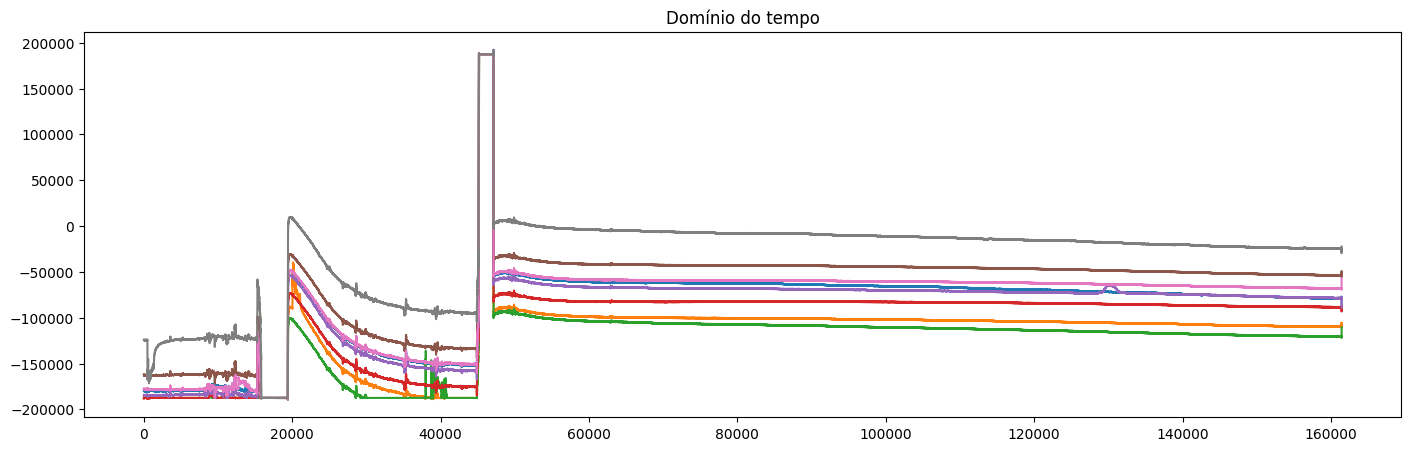

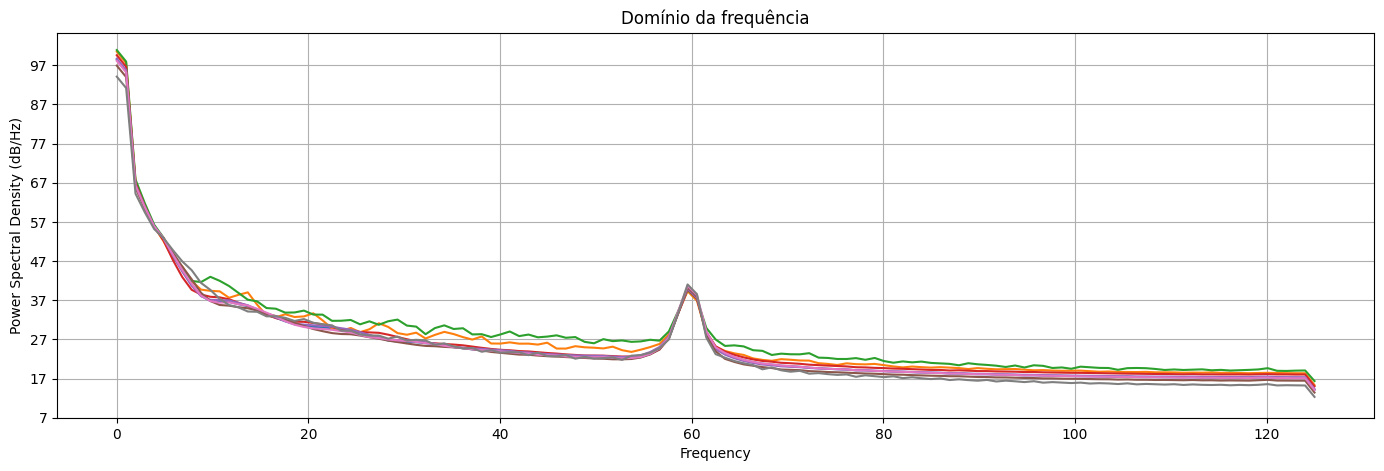

In [10]:
data_filtered = butter_notch(data.flatten(), 60)
data_filtered = data_filtered.reshape(int(data_filtered.shape[0] / 8), 8)
print_graphs(data_filtered)

**Tarefa**: Executem a mesma tarefa com os outros filtros, ajustando o tempos menores (10, 20 segundos...) para visualizar melhor os dados no domínio da frequência e as suas diferenças.